In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Plot Training Data

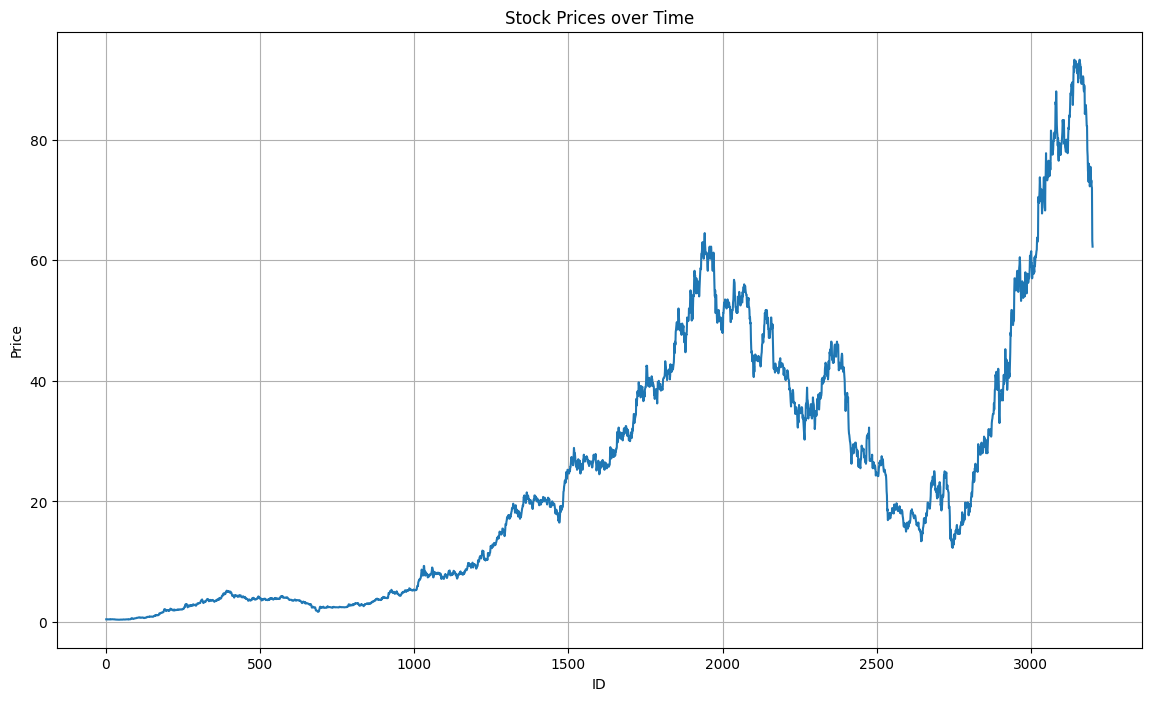

In [3]:
# Load your data
df_show = pd.read_csv('/kaggle/input/stock-investment-prediction/train.csv')
plt.figure(figsize=(14,8))
plt.plot(df_show['id'], df_show['price'])
plt.title('Stock Prices over Time')
plt.xlabel('ID')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# LinearRegression-Model

In [ ]:
# Load training data from CSV file
train_data = pd.read_csv("/kaggle/input/stock-investment-prediction/train.csv")

# Define predictor variables (independent variable)
X = train_data['id'].values.reshape(-1,1)

# Define target variable (dependent variable)
Y = train_data['price'].values.reshape(-1,1)

# Split the data into train and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=0)

# Train the model
model = LinearRegression()  
model.fit(X_train, Y_train)

# Make Predictions on validation set
Y_pred = model.predict(X_val)

# Calculate MAE
mae = mean_absolute_error(Y_val, Y_pred)

print("Mean Absolute Error: ", mae)

In [ ]:
# Load test data
test_data = pd.read_csv("/kaggle/input/stock-investment-prediction/test.csv")
X_test = test_data['id'].values.reshape(-1,1)

# Make Predictions
Y_pred = model.predict(X_test)

# Create a dataframe for submission
submission = pd.DataFrame({'id': test_data['id'], 'price': Y_pred.flatten()})

# Save the submission dataframe as csv file
submission.to_csv('LiReg.csv', index=False)

# LSTM-Model (best)

In [ ]:
# Load your data
df = pd.read_csv('/kaggle/input/stock-investment-prediction/train.csv')

# Preprocess your data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['price'].values.reshape(-1,1))

# Define look back period and split inputs/labels
look_back = 2
inputs = []
labels = []
for i in range(look_back, len(scaled_data)):
    inputs.append(scaled_data[i-look_back:i, 0])
    labels.append(scaled_data[i, 0])
inputs = np.array(inputs)
labels = np.array(labels)

# Reshape the inputs
inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(inputs.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
model.fit(inputs, labels, epochs=30, batch_size=32, callbacks=[EarlyStopping(monitor='loss', patience=3)])

# Now predict future stock prices
total_data = df['price'].values
inputs = total_data[len(total_data) - look_back:]  # take the last 'look_back' elements
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
predicted_price = []
for i in range(300):  # predict the next 300 prices
    inputs_updated = inputs[i:i+look_back]
    inputs_updated = np.reshape(inputs_updated, (1, inputs_updated.shape[0], 1))
    predicted = model.predict(inputs_updated)
    predicted_price.append(scaler.inverse_transform(predicted))
    inputs = np.concatenate((inputs, predicted))

# Write the predicted prices to csv
submission_df = pd.DataFrame({'id': list(range(3201, 3501)), 'price': [item[0][0] for item in predicted_price]})
submission_df.to_csv('LSTM12.csv', index=False)
model.save("LSTM12.h5")

# Add Noise

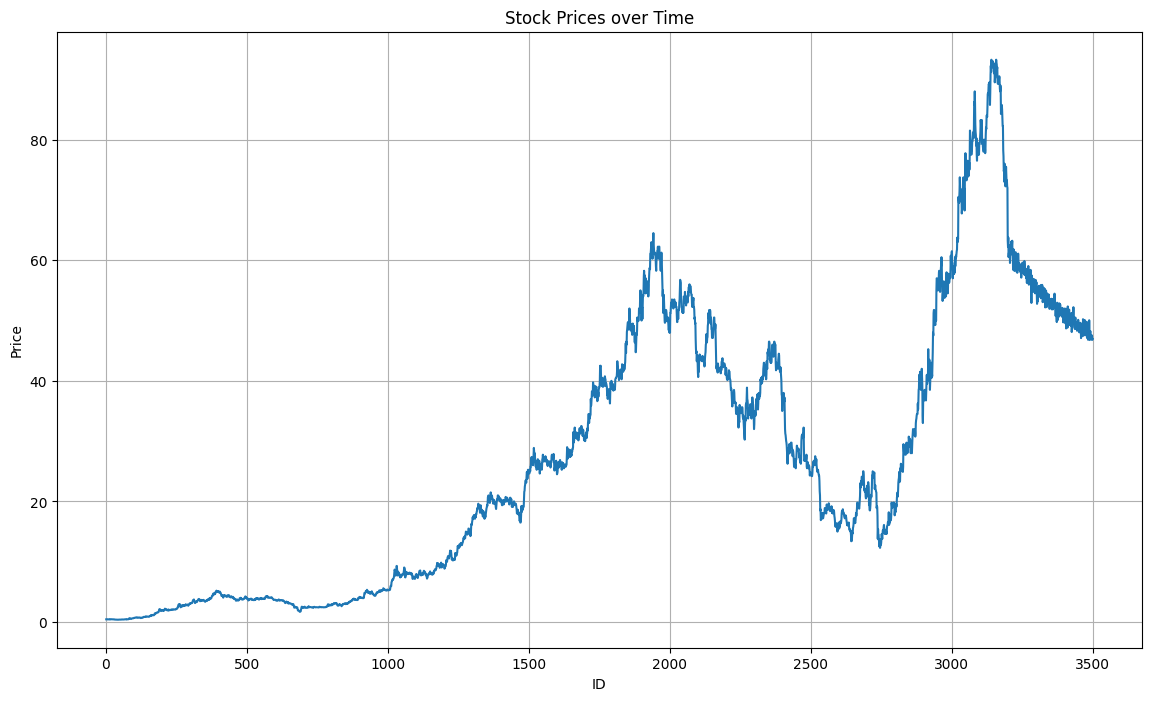

In [4]:
df_LSTM = pd.read_csv('/kaggle/input/stock-ensemble/LSTM3-best.csv')

noise = np.random.normal(loc=0, scale=1, size=df_LSTM['price'].shape) # Change the location and scale according to your needs
df_LSTM['price'] = df_LSTM['price'] + noise

result = pd.concat([df_show,df_LSTM])

plt.figure(figsize=(14,8))
plt.plot(result['id'], result['price'])
plt.title('Stock Prices over Time')
plt.xlabel('ID')
plt.ylabel('Price')
plt.grid(True)
plt.show()

df_LSTM.to_csv('LSTM18_Noise.csv', index=False)

# Ensemble Methods

In [5]:
# Read the prediction CSV files
pred1 = pd.read_csv('/kaggle/input/stock-ensemble/LSTM16_Noise.csv')
pred2 = pd.read_csv('/kaggle/input/stock-ensemble/LSTM17_Noise.csv')
pred3 = pd.read_csv('/kaggle/input/stock-ensemble/LSTM3-best.csv')

# Ensure the predictions are aligned and in the same order
assert(pred1.index.equals(pred2.index))
assert(pred1.index.equals(pred3.index))

# Average predictions
average_pred = (pred1['price'] + pred2['price'] + pred3['price']) / 3

# Create a new DataFrame for the averaged predictions
ensemble_pred = pd.DataFrame({'id': pred1['id'], 'price': average_pred})

# Save to a new CSV file
ensemble_pred.to_csv('LSTM19_ensemble_.csv', index=False)